<div>
<font color=white size=5>
Implementation Part2:Realistic Plate Recognition </br>
Functions:
</div>

In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
# loading template images : using address of files to load all pattern images 
# we also turn their colors to gray for makeing sure it would be fine durring ahead process
def load(address):
    patterns = {}
    for name in sorted(os.listdir(address)):
            num = os.path.splitext(name)[0]
            path = os.path.join(address, name)
            image_data = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            if image_data is not None:
                patterns[num] = image_data
    return patterns

# now we want to take each picture of license plates and turn it apart to each character of license numbers , then we sort and merge it together for correlation process

def split_func(input_img, show_plots=True):
    if isinstance(input_img, str):
        real_image = cv2.imread(input_img)
        if real_image is None:
            return []
        grayed = cv2.cvtColor(real_image, cv2.COLOR_BGR2GRAY)
        h, w, _ = real_image.shape
    else:
        grayed = input_img.copy() if len(input_img.shape) == 2 else cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
        h, w = grayed.shape
    # using MedianBlur which is better for noise from the deblur filter
    blurred = cv2.medianBlur(grayed, 5)
    # apply threshold
    _, black_white = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    # using a standard kernel to close gaps in characters
    filling_elements = np.ones((3,3), np.uint8)
    clean_image = cv2.morphologyEx(black_white, cv2.MORPH_CLOSE, filling_elements, iterations=2)
    # founding
    shapes, _ = cv2.findContours(clean_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    possible_shapes = []
    for shape in shapes:
        x_c, y_c, w_c, h_c = cv2.boundingRect(shape)
        shape_area = cv2.contourArea(shape)
        aspect_ratio = w_c / float(h_c)
        # remove noises and big founded shapes
        # These conditions are logical guesses based on typical character filtering
        if (h_c > h * 0.35) and (aspect_ratio < 1.2) and (shape_area > 500):
            possible_shapes.append(shape)
            
    # now we sort the filtered shapes by x-position.
    shape_list = sorted(possible_shapes, key=lambda c: cv2.boundingRect(c)[0])
    final_list = []
    for char in shape_list:
        x, y, w_c, h_c = cv2.boundingRect(char)
        # Corrected slicing
        cropped_image = grayed[y:y+h_c, x:x+w_c]
        final_list.append(cropped_image)
        
    if show_plots and final_list:
        plt.figure(figsize=(len(final_list) * 1.5, 2))
        if isinstance(input_img, str):
            plot_title = f'Segmented Characters from {os.path.basename(input_img)}'
        else:
            # Corrected string definition
            plot_title = 'Segmented Characters from Image'
        plt.suptitle(plot_title)
        for i, character in enumerate(final_list):
            plt.subplot(1, len(final_list), i + 1)
            plt.imshow(character, cmap='gray')
            plt.axis('off')
        plt.show()
        
    return final_list

def split_func2(grayed, show_plots=True): #Just the same as split_func;but instead of the image address,it directly gets the grayed image as input
    h, w = grayed.shape
    # using MedianBlur which is better for noise from the deblur filter
    blurred = cv2.medianBlur(grayed, 5)
    # apply threshold
    _, black_white = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    # using a standard kernel to close gaps in characters
    filling_elements = np.ones((3,3), np.uint8)
    clean_image = cv2.morphologyEx(black_white, cv2.MORPH_CLOSE, filling_elements, iterations=2)
    # founding
    shapes, _ = cv2.findContours(clean_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    possible_shapes = []
    for shape in shapes:
        x_c, y_c, w_c, h_c = cv2.boundingRect(shape)
        shape_area = cv2.contourArea(shape)
        aspect_ratio = w_c / float(h_c)
        # remove noises and big founded shapes
        # These conditions are logical guesses based on typical character filtering
        if (h_c > h * 0.35) and (aspect_ratio < 1.2) and (shape_area > 500):
            possible_shapes.append(shape)
            
    # now we sort the filtered shapes by x-position.
    shape_list = sorted(possible_shapes, key=lambda c: cv2.boundingRect(c)[0])
    final_list = []
    for char in shape_list:
        x, y, w_c, h_c = cv2.boundingRect(char)
        # Corrected slicing
        cropped_image = grayed[y:y+h_c, x:x+w_c]
        final_list.append(cropped_image)
        
    if show_plots and final_list:
        plt.figure(figsize=(len(final_list) * 1.5, 2))
            # Corrected string definition
        plot_title = 'Segmented Characters from Image'
        plt.suptitle(plot_title)
        for i, character in enumerate(final_list):
            plt.subplot(1, len(final_list), i + 1)
            plt.imshow(character, cmap='gray')
            plt.axis('off')
        plt.show()
        
    return final_list


# in this part we have to indentify numbers or chars from the images , we first adapt some filters and size changes to make sure the comparision goes fair enough
# then we calculate correlation between desired image and our patterns 
# we choose the max of calculated correlation ratios (which is between -1 and 1) for best fitted image and that is our choice 
def recognize_func(char_list, patterns):
    #  getting a standard size 
    first = next(iter(patterns.values()))
    standard_h, standard_w = first.shape
    ans = ""
    correlations_ratios = []
    # now we loop through each segment to calcuate correlation
    for x in char_list:
        best = -1.0
        choice = ' '
        # first we prepare image in case of size 
        original_h, original_w = x.shape
        ratio = min(standard_w/original_w, standard_h/original_h)
        new_w, new_h = int(original_w*ratio), int(original_h*ratio)
        resized = cv2.resize(x, (new_w, new_h), interpolation=cv2.INTER_AREA)
        # then we centreize the image for better handing
        padded = np.full((standard_h, standard_w), 255, dtype=np.uint8)
        x_start = (standard_w - new_w) // 2
        y_start = (standard_h - new_h) // 2
        padded[y_start:y_start+new_h, x_start:x_start+new_w] = resized
        # apply threshold to clean image from noises and make it more clear
        _, prepared = cv2.threshold(padded, 128, 255, cv2.THRESH_BINARY)
        # now we compare each segment with all patterns in this loop
        for name, image in patterns.items():
           # resize to avoid any mismatch
            template_resized = cv2.resize(image, (standard_w, standard_h))
            # calculate the score (correlation ratio which is between -1 and 1)
            match_result = cv2.matchTemplate(prepared, template_resized, cv2.TM_CCOEFF_NORMED)
            _, similarity_score, _, _ = cv2.minMaxLoc(match_result)
            # consider the best one through loop with choosing the max rate
            if similarity_score > best:
                best = similarity_score
                choice = name      
        # add the best matched one 
        ans += choice
        correlations_ratios.append(best)
    if len(ans) == 7: 
        ans = f"{ans[0:2]} {ans[2]} {ans[3:7]}"
    return ans, correlations_ratios


def deblurFilter_horizontal(Img_gray,p):#Equation linking signal values before and after blurring:y[n]=(1-p)*x[n]+p*y[n-1] 
    Img_grayed=Img_gray.copy()
    rowNum,colNum=Img_grayed.shape
    #Row debluring
    Img_grayed=Img_grayed.astype(float)
    for i in range(0,rowNum):
      temp=Img_grayed[i,:]  #temp=y[n],the value of i_th row after a blurring filter has been applied
      temp=temp.astype(float)
      temp2=np.array([0]*colNum)
      temp2[1:colNum]=temp[0:colNum-1] #temp2=y[n-1]
      temp2=temp2.astype(float)
      ans=temp-p*temp2 #ans=y[n]-p*y[n-1]
      ans=ans.astype(float)
      Img_grayed[i,:]=ans/(1-p)#original value of i_th row=x[n]=(y[n]-p*y[n-1])/(1-p)
    Img_grayed=Img_grayed.astype(int)
    Img_grayed = np.clip(Img_grayed, 0, 255)
    Img_grayed=Img_grayed.astype(np.uint8)#This is nessesary,otherwise cv2 library doesn't recognize this 2D array as a photo and functions of this library could not be applied
    return Img_grayed


def deblurFilter_vertical(Img_gray,p):#Equation linking signal values before and after blurring:y[n]=(1-p)*x[n]+p*y[n-1] 
    Img_grayed=Img_gray.copy()
    rowNum,colNum=Img_grayed.shape
    #Column debluring
    Img_grayed=Img_grayed.astype(float)
    for i in range(0,colNum):
      temp=Img_grayed[:,i] #temp=y[n],the value of i_th column after a blurring filter has been applied
      temp=temp.astype(float)
      temp2=np.array([0]*rowNum)
      temp2[1:rowNum]=temp[0:rowNum-1]#temp2=y[n-1]
      temp2=temp2.astype(float)
      ans=temp-p*temp2 #ans=y[n]-p*y[n-1]
      ans=ans.astype(float)
      Img_grayed[:,i]=ans/(1-p)#original value of i_th column=x[n]=(y[n]-p*y[n-1])/(1-p)
    Img_grayed=Img_grayed.astype(int)
    Img_grayed = np.clip(Img_grayed, 0, 255)
    Img_grayed=Img_grayed.astype(np.uint8)#same as previous function,this is nessesary in order to make the output appliable to cv2 functions
    return Img_grayed

    
def OptimumDeblur(input,samples):
    if isinstance(input, str):
        real_image = cv2.imread(input) 
    else:
        real_image = input.copy() 
    # getting the size of image 
    h, w, _ = real_image.shape
    # we first change color to gray and then apply blur filter to improve quality 
    grayed = cv2.cvtColor(real_image, cv2.COLOR_BGR2GRAY)
    grayed=np.array(grayed)
    chars = split_func2(grayed, show_plots=False)
    # calling the recognition function to identify chars
    output, rates = recognize_func(chars, samples)
    if(len(rates) >0):
     maxCorrelation=sum(rates) / len (rates)
    else:
     maxCorrelation=-1
    bestChoicesofar=grayed
    for i in range (51,100,2):#We check the result of horizontal deblurring filter for parameters 0.51,0.53,...,0.99 
        j=i/100
        temp=deblurFilter_horizontal(grayed,j)
        chars = split_func2(temp, show_plots=False)
        # calling the recognition function to identify chars
        output, rates = recognize_func(chars, samples)
        if(len(rates)==7):#This is a mandatory yet insufficient condition for a result to be acceptable
            if((sum(rates) / len (rates)) > maxCorrelation):#if 7 chars have been recognized and the average of_
                maxCorrelation=sum(rates) / len (rates)#_correlation coefficients is higher than all previous results;this result has been the best filtering choice so far
                bestChoicesofar=temp
        temp=deblurFilter_horizontal(grayed,-i/100)
        chars = split_func2(temp, show_plots=False)
      # calling the recognition function to identify chars
        output, rates = recognize_func(chars, samples)
        if(len(rates)==7):
            if(sum(rates) / len (rates) > maxCorrelation):
                maxCorrelation=sum(rates) / len (rates)
                bestChoicesofar=temp
    bestChoice=bestChoicesofar#Till here we've got the best result possible using horizontal beblurring(it can be the original image itself).Now we perform the best_ 
    for i in range (51,100,2):#_vertical deblurring possible on this result to get the final result.
        j=i/100
        temp=deblurFilter_vertical(bestChoicesofar,j)
        chars = split_func2(temp, show_plots=False)
        output, rates = recognize_func(chars, samples)
        if(len(rates)==7):
            if(sum(rates) / len (rates) > maxCorrelation):
                maxCorrelation=sum(rates) / len (rates)
                bestChoice=temp
        temp=deblurFilter_vertical(bestChoicesofar,-i/100)
        chars = split_func2(temp, show_plots=False)
    # calling the recognition function to identify chars
        output, rates = recognize_func(chars, samples)
        if(len(rates)==7):
            if(sum(rates) / len (rates) > maxCorrelation):
                maxCorrelation=sum(rates) / len (rates)
                bestChoice=temp

    chars = split_func2(bestChoice, show_plots=True) #Performing recognition on the best result and indicating outputs
    # calling the recognition function to identify chars
    output, rates = recognize_func(chars, samples)
    return output,rates


<div>
<font color=yellow size=5>
Q1_Running recognition on realistic plate images without deblurring:
</div>

In [2]:
letters_path = "..//letters"
numbers_path = "..//numbers"
plates_path = "..//realistic"
#loading sources
number_samples = load(numbers_path)
letter_samples = load(letters_path)
samples = {**number_samples, **letter_samples}
# at the end we want to verify if our system works or not so we save the correct answers  
plates = ['p1.jpg', 'p2.jpg', 'p3.jpg', 'p4.jpg']
correct_answers = {
        'p1.jpg': '98 C 7445', 'p2.jpg': '56 A 7495',
        'p3.jpg': '79 B 1208', 'p4.jpg': '93 D 4328'
}
# 4. Loop through each license plate file for testing.
for plate_name in plates:
    plate_path = os.path.join(plates_path, plate_name)
    print(f"\nProcessing: {plate_name}")
    # first let's split the image and take it out chars which are needed
    chars = split_func(plate_path, show_plots=True)
    # calling the recognition function to identify chars
    output, rates = recognize_func(chars, samples)
    print(f"Result: {output}")
    print(f"Scores: {[f'{s:.2f}' for s in rates]}")


Processing: p1.jpg
Result: 
Scores: []

Processing: p2.jpg
Result: 
Scores: []

Processing: p3.jpg
Result: 
Scores: []

Processing: p4.jpg
Result: 
Scores: []


<div>
<font color=yellow size=5>
Q2,3_Manually defiltering plates:
</div>

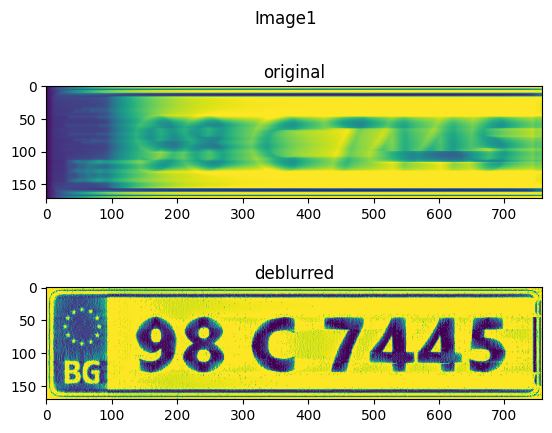

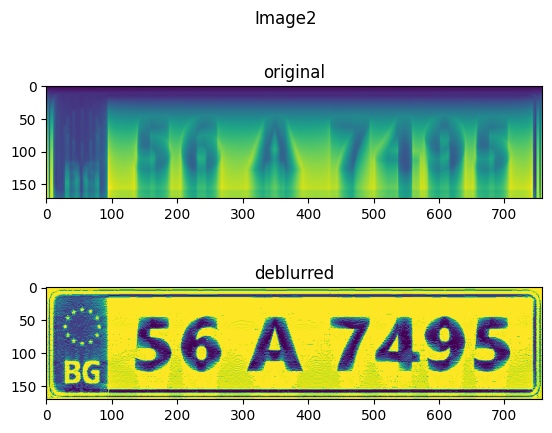

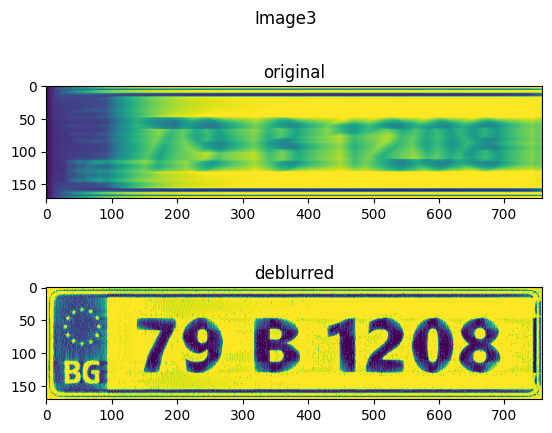

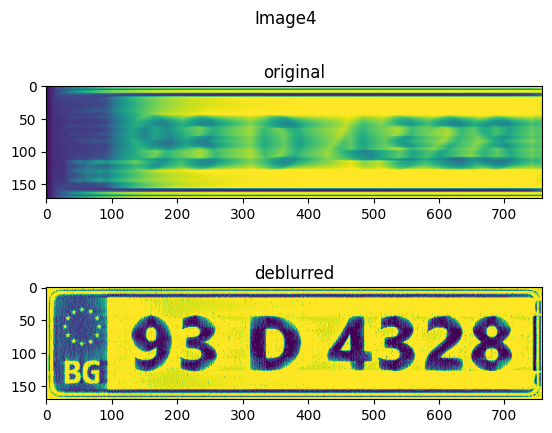

In [3]:
letters_path = "..//letters"
numbers_path = "..//numbers"

plate_path_raw = "..//realistic//"
for i in range(1,5):
 plate_path=plate_path_raw+"p"+ str(i)+".jpg"
 real_image = cv2.imread(plate_path)
 grayed = cv2.cvtColor(real_image, cv2.COLOR_BGR2GRAY)
 grayed=np.array(grayed)
 if(i==2):
  grayed2=deblurFilter_vertical(grayed,0.99)
 else:
  grayed2=deblurFilter_horizontal(grayed,0.99)
 samples = {**number_samples, **letter_samples}
 plt.subplot(2,1,1)
 plt.imshow(grayed)
 plt.title("original")
 plt.subplot(2,1,2)
 plt.imshow(grayed2)
 plt.title("deblurred")
 plt.suptitle("Image"+str(i))
 plt.show()

<div>
<font color=yellow size=5>
Q4_DeFiltering Images and passing them to Recognize Function:
</div>


Processing: p1.jpg


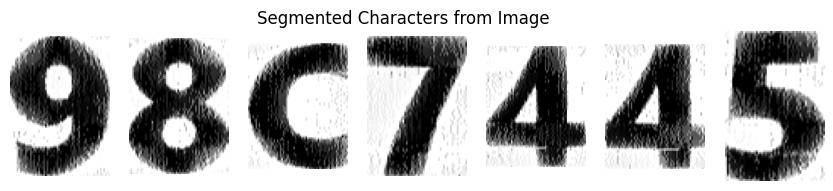

Result: 98 C 7445
Scores: ['0.82', '0.77', '0.74', '0.79', '0.87', '0.79', '0.73']

Processing: p2.jpg


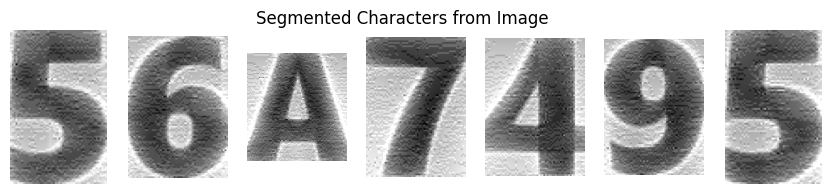

Result: 56 A 7495
Scores: ['0.71', '0.78', '0.77', '0.74', '0.73', '0.78', '0.71']

Processing: p3.jpg


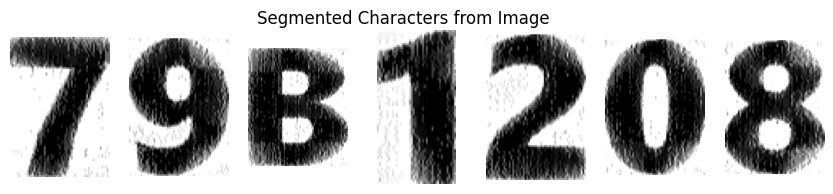

Result: 79 B 1208
Scores: ['0.80', '0.79', '0.76', '0.72', '0.77', '0.76', '0.73']

Processing: p4.jpg


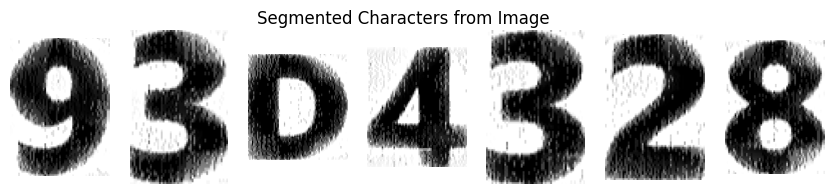

Result: 93 D 4328
Scores: ['0.81', '0.75', '0.66', '0.85', '0.76', '0.77', '0.74']


In [4]:
letters_path = "..//letters"
numbers_path = "..//numbers"
plates_path = "..//realistic"
#loading sources
number_samples = load(numbers_path)
letter_samples = load(letters_path)
samples = {**number_samples, **letter_samples}
# at the end we want to verify if our system works or not so we save the correct answers  
plates = ['p1.jpg', 'p2.jpg', 'p3.jpg', 'p4.jpg']
correct_answers = {
        'p1.jpg': '98 C 7445', 'p2.jpg': '56 A 7495',
        'p3.jpg': '79 B 1208', 'p4.jpg': '93 D 4328'
}
# 4. Loop through each license plate file for testing.
for plate_name in plates:
    plate_path = os.path.join(plates_path, plate_name)
    print(f"\nProcessing: {plate_name}")
    output, rates = OptimumDeblur(plate_path,samples)
    print(f"Result: {output}")
    print(f"Scores: {[f'{s:.2f}' for s in rates]}")

<div>
<font color=yellow size=5>
Q5_Downsampling:
</div>


Analyzing quality effects on: p1.jpg


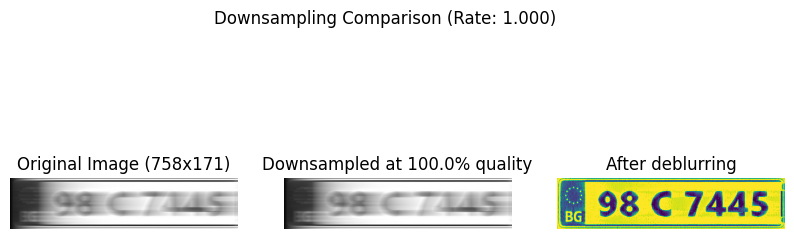

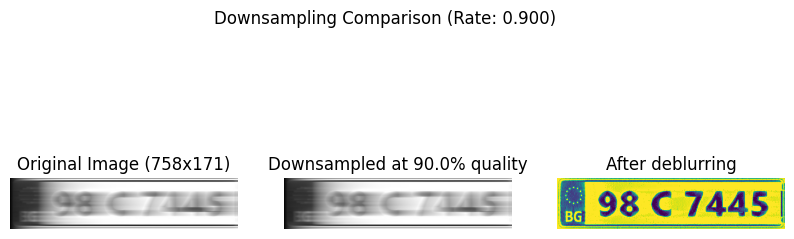

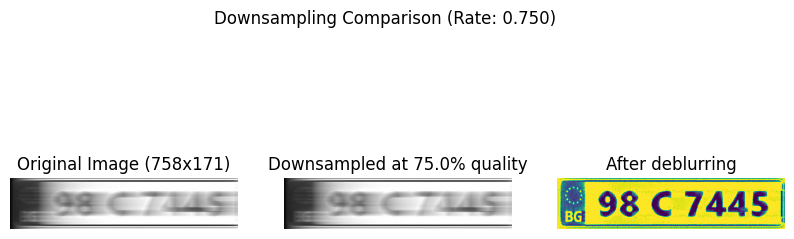

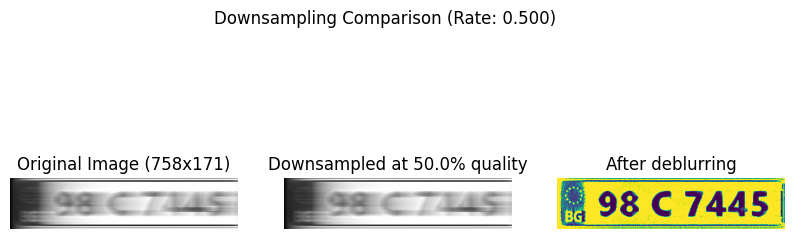

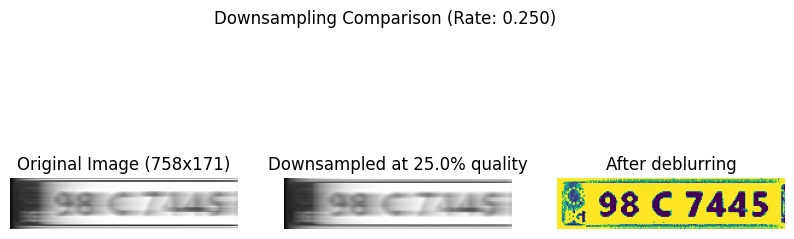

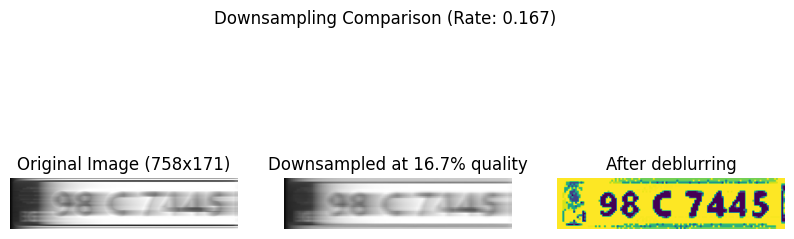

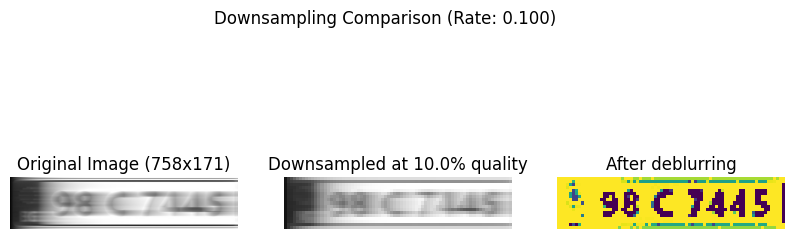


Results Table: Accuracy vs. Quality
Quality | Avg Score        | Correct/wrong | Recognized Text
--------------------------------------------------------------
1.000   | 0.7769           | True           |98 C 7445
0.900   | 0.7608           | True           |98 C 7445
0.750   | 0.7599           | False          |98C75
0.500   | 0.6757           | False          |A98C75
0.250   | 0.0000           | False          |
0.167   | 0.0000           | False          |
0.100   | 0.0000           | False          |

Conclusion: The system works down to approx. 0.900 quality.


In [8]:
plate_down = 'p1.jpg'
path_down = os.path.join(plates_path, plate_down)
save_path='lowQualityImage.jpg'
print(f"\nAnalyzing quality effects on: {plate_down}")
original_plate_image = cv2.imread(path_down)
correct_text = correct_answers[plate_down]
# diffrent rates of down sampling : 
rates = [1.0,0.9, 0.75, 0.5, 0.25, 1/6, 1/10]
results = []
# check the effect in diffrent rates through looping : 
for rate in rates:
    h, w, _ = original_plate_image.shape
    low_quality_image = cv2.resize(original_plate_image, (int(w*rate), int(h*rate)), interpolation=cv2.INTER_AREA)
    grayed = cv2.cvtColor(low_quality_image, cv2.COLOR_BGR2GRAY)
    if(plate_down == 'p2.jpg'):
        deblurred_gray=deblurFilter_vertical(grayed,0.99)
    else:
     deblurred_gray=deblurFilter_horizontal(grayed,0.99)
    # here is the plot
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 3, 1); plt.imshow(cv2.cvtColor(original_plate_image, cv2.COLOR_BGR2RGB)); plt.title(f'Original Image ({w}x{h})'); plt.axis('off')
    plt.subplot(1, 3, 2); plt.imshow(cv2.cvtColor(low_quality_image, cv2.COLOR_BGR2RGB)); plt.title(f'Downsampled at {rate*100:.1f}% quality'); plt.axis('off')
    plt.subplot(1, 3, 3); plt.imshow(deblurred_gray); plt.title(f'After deblurring'); plt.axis('off')
    plt.suptitle(f"Downsampling Comparison (Rate: {rate:.3f})")
    plt.show()
    # now we want to run again the process of identification with low qaulity images 
    parts = split_func2(deblurred_gray, show_plots=False)
    text_result, rates_list = recognize_func(parts, samples)
    # checking the results
    check = (text_result == correct_text)
    average_rate = np.mean(rates_list) if rates_list else 0
    results.append((rate, text_result, check, average_rate))
print("\nResults Table: Accuracy vs. Quality")
print("Quality | Avg Score        | Correct/wrong | Recognized Text")
print("--------------------------------------------------------------")
# now we want to find min qaulity of images in which the system is working
min_accepted_quality = None
for rate, text, correct, score in sorted(results, key=lambda x: x[0], reverse=True):
    print(f"{rate:<7.3f} | {score:<16.4f} | {str(correct):<8}       |{text}")
    if correct: 
        min_accepted_quality = rate
if min_accepted_quality: 
    print(f"\nConclusion: The system works down to approx. {min_accepted_quality:.3f} quality.")

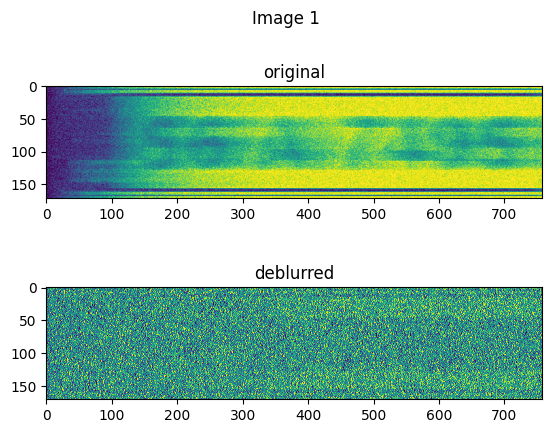

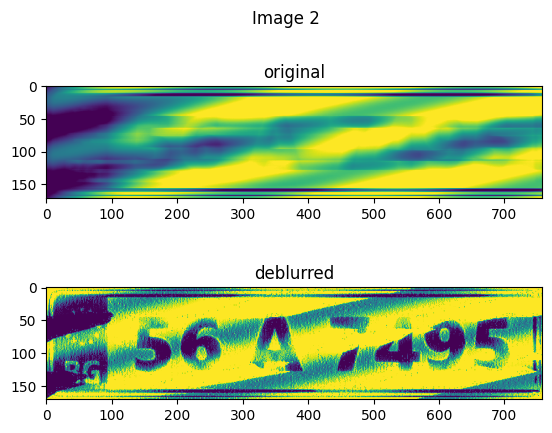

In [10]:
plate_path_raw = "..//noisy//n"
letters_path = "..//letters"
numbers_path = "..//numbers"
samples = {**number_samples, **letter_samples}
for i in range(1,3):
  plate_path=plate_path_raw+str(i)+".jpg"
  real_image = cv2.imread(plate_path)
  grayed = cv2.cvtColor(real_image, cv2.COLOR_BGR2GRAY)
  grayed=np.array(grayed)
  grayed2=deblurFilter_horizontal(grayed,0.99)
  plt.subplot(2,1,1)
  plt.imshow(grayed)
  plt.title("original")
  plt.subplot(2,1,2)
  plt.imshow(grayed2)
  plt.title("deblurred")
  plt.suptitle("Image "+str(i))
  plt.show()